<a href="https://colab.research.google.com/github/gshah8/UCF/blob/master/Machine_Learning/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 3

The goal of this homework is to learn how to leverage pretrained convnets and to use some visualization techniques.
You will work with the data set *cats vs dogs* and use the pretrained convnet VGG19.

Experiment with different classifiers, trying to maximize the validation accuracy. You only need to show one classifier.

---









##Download the data

In [177]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 00:50:55--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 2607:f8b0:4001:c1a::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   116MB/s    in 0.6s    

2019-04-18 00:50:55 (116 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
import os
import zipfile


local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

##Load the convolutional base

In [0]:
from tensorflow.keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

## Problem 1

Do feature extraction with data augmentation.

We need to freeze the convolutional base for Problem 1

In [0]:
conv_base.trainable = False

In [193]:
out = conv_base.output
out=layers.Flatten()(out)
out=layers.Dense(256, activation='relu')(out)
out = layers.Dense(1, activation='sigmoid')(out)
model = models.Model(inputs=[conv_base.input], outputs=[out])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
#There are 22 layers in vgg19
training_layer_idx=22
for idx,layer in enumerate(model.layers):
    layer.trainable = idx >= training_layer_idx

In [198]:
# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 19s 188ms/step - loss: 0.6643 - acc: 0.5925 - val_loss: 0.5752 - val_acc: 0.7500
Epoch 2/30
100/100 [==============================] - 18s 182ms/step - loss: 0.5778 - acc: 0.7255 - val_loss: 0.4962 - val_acc: 0.8010
Epoch 3/30
100/100 [==============================] - 20s 198ms/step - loss: 0.5381 - acc: 0.7520 - val_loss: 0.4725 - val_acc: 0.7970
Epoch 4/30
100/100 [==============================] - 18s 183ms/step - loss: 0.5035 - acc: 0.7675 - val_loss: 0.4146 - val_acc: 0.8190
Epoch 5/30
100/100 [==============================] - 20s 196ms/step - loss: 0.4858 - acc: 0.7835 - val_loss: 0.3954 - val_acc: 0.8440
Epoch 6/30
100/100 [==============================] - 19s 191ms/step - loss: 0.4649 - acc: 0.7875 - val_loss: 0.3840 - val_acc: 0.8460
Epoch 7/30
100/100 [==============================] - 20s 196ms/step - loss: 0.4427 - acc: 0.8020 - val_lo

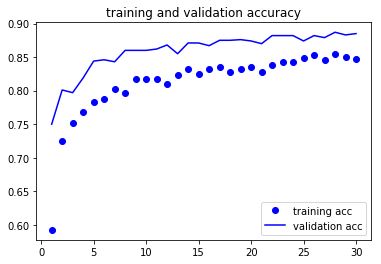

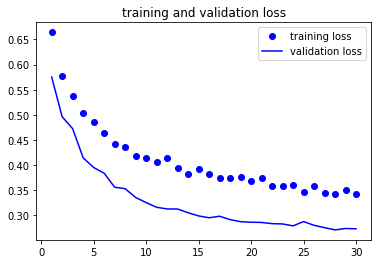

In [199]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [201]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.27347360908985135
Validation accuracy: 0.885


In [0]:
model_fname = 'cats_and_dogs_prob1.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)

## Problem 2

Do fine-tuning with data augmentation. 

In [206]:
name = 'cats_and_dogs_prob1.h5'
path = F"/content/{name}"
model2 = load_model(path)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [211]:
#Out of 22 layers in vgg19, I want to unfreeze the last four.
training_layer_idx=18
for idx,layer in enumerate(model2.layers):
    layer.trainable = idx >= training_layer_idx

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model2.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model2.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 19s 194ms/step - loss: 0.3471 - acc: 0.8445 - val_loss: 0.2630 - val_acc: 0.8940
Epoch 2/30
100/100 [==============================] - 20s 202ms/step - loss: 0.3257 - acc: 0.8620 - val_loss: 0.2469 - val_acc: 0.8990
Epoch 3/30
100/100 [==============================] - 19s 188ms/step - loss: 0.2883 - acc: 0.8750 - val_loss: 0.2732 - val_acc: 0.8930
Epoch 4/30
100/100 [==============================] - 19s 189ms/step - loss: 0.2719 - acc: 0.8775 - val_loss: 0.2189 - val_acc: 0.9090
Epoch 5/30
100/100 [==============================] - 19s 189ms/step - loss: 0.2483 - acc: 0.8930 - val_loss: 0.2194 - val_acc: 0.9000
Epoch 6/30
100/100 [==============================] - 20s 200ms/step - loss: 0.2335 - acc: 0.8955 - val_loss: 0.2093 - val_acc: 0.9160
Epoch 7/30
100/100 [==============================] - 19s 191ms/step - loss: 0.2436 - acc: 0.9060 - val_lo

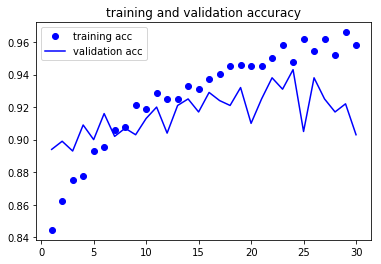

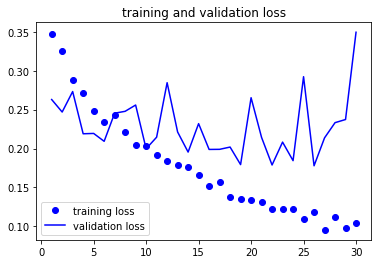

In [213]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [214]:
val_loss, val_acc = model2.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.34946351204067466
Validation accuracy: 0.903


In [0]:
model_fname = 'cats_and_dogs_prob2.h5' 
model2.save(model_fname)

In [0]:
from google.colab import files
with open(model_fname, 'r') as f:
  files.download(model_fname)

## Problem 3

Visualize heatmaps of class activation for the the model obtained in Problem 2.


In [0]:
import os
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
#from keras import backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [0]:
#from tensorflow.keras.models import load_model
name = 'cats_and_dogs_prob2.h5'
path = F"/content/{name}"
model3 = load_model(path)

In [223]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [228]:
# getting 30 random images from validation set for 
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=30,
    class_mode='binary')
val_images, val_labels = next(validation_generator)

Found 1000 images belonging to 2 classes.


In [229]:
last_conv_layer = model3.get_layer('block5_conv4')
last_conv_layer

In [0]:
def process_image(image_path):
    x = np.expand_dims(image_path, axis=0)
    
    grads = K.gradients(model3.output[0], last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model3.input], [pooled_grads, last_conv_layer.output[0], model3.output[0]])
    
    pooled_grads_value, conv_layer_output_value, preds = iterate([x])
    
    if preds[0] < 1.0:
      if preds[0] < 0.5:
          conv_layer_output_value = 1-conv_layer_output_value 
      for i in range(512):
          conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - heatmap.min())/(heatmap.max()-heatmap.min())
    
    heatmap_adj = cv2.resize(1-heatmap, (image_path.shape[1], image_path.shape[0]))
    heatmap_adj = np.uint8(255 * heatmap_adj)
    heatmap_adj = cv2.applyColorMap(heatmap_adj, cv2.COLORMAP_JET)
    
    superimposed = np.uint8(heatmap_adj * 0.4 + np.uint8(255 * image_path) * 0.6)
    
    return superimposed, preds[0],heatmap_adj

In [230]:
sample=val_images[1,:]
sample.ndim

3

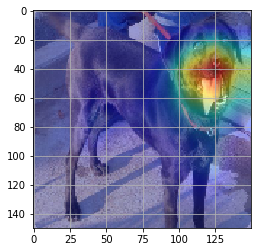

In [176]:

#f=np.expand_dims(f, axis=0)
superimposed_img, pred, heatmap = process_image(sample)
plt.imshow(superimposed_img)
plt.grid(None)
plt.show()

## Problem 4

Build an activation model that takes as input an image and produces as output the activation of the last conv layer of the model obtained in Problem 2. Using this activation model obtain the corresponding activations for the validation images. Apply t-SNE visualization to these activations to see how well the convnet separates cats from dogs.